<a href="https://colab.research.google.com/github/henriqueburis/sinalizacoa_horizonta_object-detection-fasterrcnn/blob/main/object_detection_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###code https://www.kaggle.com/code/pdochannel/object-detection-fasterrcnn-tutorial/notebook

In [ ]:
!unzip /content/teste.v2i.coco.zip

In [ ]:
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

In [ ]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
# our dataset is in cocoformat, we will need pypcoco tools
#!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(500, 500), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(500, 500), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class Dataset_Detection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/placas/"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'sinali', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'frente', 'supercategory': 'sinali'},
 2: {'id': 2, 'name': 'frente_esqueda', 'supercategory': 'sinali'},
 3: {'id': 3, 'name': 'frete_esqueda', 'supercategory': 'sinali'},
 4: {'id': 4, 'name': 'sinali', 'supercategory': 'sinali'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['sinali', 'frente', 'frente_esqueda', 'frete_esqueda', 'sinali']

In [ ]:
train_dataset = Dataset_Detection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


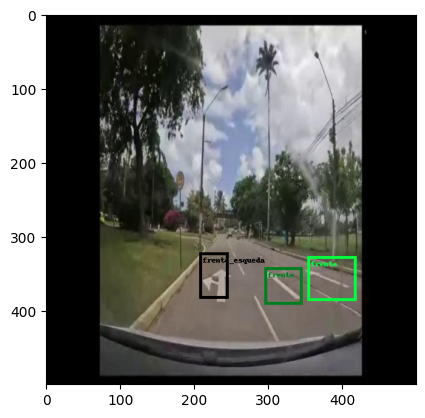

In [ ]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

24

In [ ]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 145MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [ ]:
device = torch.device("cpu") # use GPU to train

In [ ]:
model = model.to(device)

In [ ]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [ ]:
import sys

In [ ]:
### train
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=100

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 6/6 [00:41<00:00,  6.92s/it]


Epoch 0, lr: 0.010000, loss: 0.917933, loss_classifier: 0.408294, loss_box: 0.487856, loss_rpn_box: 0.004930, loss_object: 0.016853


100%|██████████| 6/6 [00:30<00:00,  5.12s/it]


Epoch 1, lr: 0.010000, loss: 1.428587, loss_classifier: 0.739276, loss_box: 0.661088, loss_rpn_box: 0.005871, loss_object: 0.022352


100%|██████████| 6/6 [00:42<00:00,  7.13s/it]


Epoch 2, lr: 0.010000, loss: 0.670171, loss_classifier: 0.378129, loss_box: 0.266878, loss_rpn_box: 0.005533, loss_object: 0.019631


100%|██████████| 6/6 [00:42<00:00,  7.00s/it]


Epoch 3, lr: 0.010000, loss: 0.596024, loss_classifier: 0.297118, loss_box: 0.280349, loss_rpn_box: 0.004791, loss_object: 0.013767


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


Epoch 4, lr: 0.010000, loss: 0.858726, loss_classifier: 0.434427, loss_box: 0.411265, loss_rpn_box: 0.003828, loss_object: 0.009207


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


Epoch 5, lr: 0.010000, loss: 1.115905, loss_classifier: 0.516776, loss_box: 0.589458, loss_rpn_box: 0.003566, loss_object: 0.006105


100%|██████████| 6/6 [00:23<00:00,  3.92s/it]


Epoch 6, lr: 0.010000, loss: 1.594066, loss_classifier: 0.721340, loss_box: 0.864124, loss_rpn_box: 0.002775, loss_object: 0.005828


100%|██████████| 6/6 [00:28<00:00,  4.80s/it]


Epoch 7, lr: 0.010000, loss: 0.894275, loss_classifier: 0.415304, loss_box: 0.470299, loss_rpn_box: 0.002933, loss_object: 0.005738


100%|██████████| 6/6 [00:30<00:00,  5.01s/it]


Epoch 8, lr: 0.010000, loss: 0.773673, loss_classifier: 0.364854, loss_box: 0.400100, loss_rpn_box: 0.002739, loss_object: 0.005980


100%|██████████| 6/6 [00:27<00:00,  4.67s/it]


Epoch 9, lr: 0.010000, loss: 0.962809, loss_classifier: 0.479485, loss_box: 0.475670, loss_rpn_box: 0.002419, loss_object: 0.005234


100%|██████████| 6/6 [00:25<00:00,  4.22s/it]


Epoch 10, lr: 0.010000, loss: 1.130286, loss_classifier: 0.536188, loss_box: 0.585752, loss_rpn_box: 0.002220, loss_object: 0.006126


100%|██████████| 6/6 [00:26<00:00,  4.43s/it]


Epoch 11, lr: 0.010000, loss: 1.043534, loss_classifier: 0.506330, loss_box: 0.530088, loss_rpn_box: 0.002278, loss_object: 0.004837


100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch 12, lr: 0.010000, loss: 1.214213, loss_classifier: 0.575507, loss_box: 0.631438, loss_rpn_box: 0.002115, loss_object: 0.005154


100%|██████████| 6/6 [00:24<00:00,  4.11s/it]


Epoch 13, lr: 0.010000, loss: 1.259480, loss_classifier: 0.522556, loss_box: 0.729810, loss_rpn_box: 0.002214, loss_object: 0.004900


100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch 14, lr: 0.010000, loss: 1.127309, loss_classifier: 0.509870, loss_box: 0.611889, loss_rpn_box: 0.001860, loss_object: 0.003690


100%|██████████| 6/6 [00:24<00:00,  4.05s/it]


Epoch 15, lr: 0.010000, loss: 1.139467, loss_classifier: 0.528056, loss_box: 0.605247, loss_rpn_box: 0.002007, loss_object: 0.004156


100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


Epoch 16, lr: 0.010000, loss: 0.967480, loss_classifier: 0.443601, loss_box: 0.517873, loss_rpn_box: 0.002085, loss_object: 0.003921


100%|██████████| 6/6 [00:26<00:00,  4.50s/it]


Epoch 17, lr: 0.010000, loss: 0.842069, loss_classifier: 0.391778, loss_box: 0.444107, loss_rpn_box: 0.001797, loss_object: 0.004387


100%|██████████| 6/6 [00:26<00:00,  4.47s/it]


Epoch 18, lr: 0.010000, loss: 0.850345, loss_classifier: 0.408360, loss_box: 0.437190, loss_rpn_box: 0.001747, loss_object: 0.003048


100%|██████████| 6/6 [00:25<00:00,  4.33s/it]


Epoch 19, lr: 0.010000, loss: 0.906009, loss_classifier: 0.410425, loss_box: 0.490872, loss_rpn_box: 0.001708, loss_object: 0.003005


100%|██████████| 6/6 [00:23<00:00,  3.95s/it]


Epoch 20, lr: 0.010000, loss: 1.209769, loss_classifier: 0.557960, loss_box: 0.645402, loss_rpn_box: 0.001724, loss_object: 0.004684


100%|██████████| 6/6 [00:25<00:00,  4.32s/it]


Epoch 21, lr: 0.010000, loss: 1.068764, loss_classifier: 0.496289, loss_box: 0.566888, loss_rpn_box: 0.001880, loss_object: 0.003707


100%|██████████| 6/6 [00:26<00:00,  4.47s/it]


Epoch 22, lr: 0.010000, loss: 0.861166, loss_classifier: 0.409237, loss_box: 0.446484, loss_rpn_box: 0.001942, loss_object: 0.003503


100%|██████████| 6/6 [00:25<00:00,  4.33s/it]


Epoch 23, lr: 0.010000, loss: 0.872862, loss_classifier: 0.422541, loss_box: 0.445068, loss_rpn_box: 0.001540, loss_object: 0.003714


100%|██████████| 6/6 [00:24<00:00,  4.10s/it]


Epoch 24, lr: 0.010000, loss: 1.008884, loss_classifier: 0.450846, loss_box: 0.552882, loss_rpn_box: 0.001486, loss_object: 0.003670


100%|██████████| 6/6 [00:26<00:00,  4.34s/it]


Epoch 25, lr: 0.010000, loss: 1.062872, loss_classifier: 0.493933, loss_box: 0.561367, loss_rpn_box: 0.001837, loss_object: 0.005735


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]


Epoch 26, lr: 0.010000, loss: 1.071935, loss_classifier: 0.495539, loss_box: 0.571348, loss_rpn_box: 0.001817, loss_object: 0.003232


100%|██████████| 6/6 [00:24<00:00,  4.08s/it]


Epoch 27, lr: 0.010000, loss: 0.954900, loss_classifier: 0.443014, loss_box: 0.506186, loss_rpn_box: 0.001676, loss_object: 0.004024


100%|██████████| 6/6 [00:24<00:00,  4.03s/it]


Epoch 28, lr: 0.010000, loss: 0.928789, loss_classifier: 0.429170, loss_box: 0.495002, loss_rpn_box: 0.001602, loss_object: 0.003015


100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Epoch 29, lr: 0.010000, loss: 0.943730, loss_classifier: 0.427988, loss_box: 0.511185, loss_rpn_box: 0.001477, loss_object: 0.003080


100%|██████████| 6/6 [00:24<00:00,  4.12s/it]


Epoch 30, lr: 0.010000, loss: 0.861161, loss_classifier: 0.428419, loss_box: 0.428616, loss_rpn_box: 0.001506, loss_object: 0.002621


100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


Epoch 31, lr: 0.010000, loss: 0.772670, loss_classifier: 0.363033, loss_box: 0.406464, loss_rpn_box: 0.001322, loss_object: 0.001851


100%|██████████| 6/6 [00:25<00:00,  4.17s/it]


Epoch 32, lr: 0.010000, loss: 0.807446, loss_classifier: 0.355598, loss_box: 0.447386, loss_rpn_box: 0.001508, loss_object: 0.002954


100%|██████████| 6/6 [00:26<00:00,  4.34s/it]


Epoch 33, lr: 0.010000, loss: 0.836103, loss_classifier: 0.388357, loss_box: 0.441875, loss_rpn_box: 0.001609, loss_object: 0.004261


100%|██████████| 6/6 [00:24<00:00,  4.03s/it]


Epoch 34, lr: 0.010000, loss: 0.837114, loss_classifier: 0.372240, loss_box: 0.460241, loss_rpn_box: 0.001525, loss_object: 0.003108


100%|██████████| 6/6 [00:24<00:00,  4.04s/it]


Epoch 35, lr: 0.010000, loss: 0.777382, loss_classifier: 0.364903, loss_box: 0.408214, loss_rpn_box: 0.001307, loss_object: 0.002958


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]


Epoch 36, lr: 0.010000, loss: 0.844331, loss_classifier: 0.393624, loss_box: 0.446044, loss_rpn_box: 0.001578, loss_object: 0.003086


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]


Epoch 37, lr: 0.010000, loss: 0.839427, loss_classifier: 0.411729, loss_box: 0.422725, loss_rpn_box: 0.001359, loss_object: 0.003614


100%|██████████| 6/6 [00:25<00:00,  4.17s/it]


Epoch 38, lr: 0.010000, loss: 0.852931, loss_classifier: 0.367600, loss_box: 0.481071, loss_rpn_box: 0.001553, loss_object: 0.002707


100%|██████████| 6/6 [00:24<00:00,  4.04s/it]


Epoch 39, lr: 0.010000, loss: 0.826650, loss_classifier: 0.376562, loss_box: 0.446358, loss_rpn_box: 0.001232, loss_object: 0.002499


100%|██████████| 6/6 [00:24<00:00,  4.02s/it]


Epoch 40, lr: 0.010000, loss: 0.843406, loss_classifier: 0.365137, loss_box: 0.475082, loss_rpn_box: 0.001252, loss_object: 0.001935


100%|██████████| 6/6 [00:25<00:00,  4.23s/it]


Epoch 41, lr: 0.010000, loss: 0.848054, loss_classifier: 0.404505, loss_box: 0.440229, loss_rpn_box: 0.001188, loss_object: 0.002131


100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Epoch 42, lr: 0.010000, loss: 0.829137, loss_classifier: 0.383443, loss_box: 0.442615, loss_rpn_box: 0.001516, loss_object: 0.001563


100%|██████████| 6/6 [00:23<00:00,  3.84s/it]


Epoch 43, lr: 0.010000, loss: 0.895135, loss_classifier: 0.406281, loss_box: 0.484614, loss_rpn_box: 0.001301, loss_object: 0.002938


100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


Epoch 44, lr: 0.010000, loss: 0.769427, loss_classifier: 0.334700, loss_box: 0.430117, loss_rpn_box: 0.001574, loss_object: 0.003036


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]


Epoch 45, lr: 0.010000, loss: 0.754049, loss_classifier: 0.346944, loss_box: 0.402309, loss_rpn_box: 0.001414, loss_object: 0.003382


100%|██████████| 6/6 [00:25<00:00,  4.18s/it]


Epoch 46, lr: 0.010000, loss: 0.741372, loss_classifier: 0.330207, loss_box: 0.407054, loss_rpn_box: 0.001423, loss_object: 0.002688


100%|██████████| 6/6 [00:24<00:00,  4.01s/it]


Epoch 47, lr: 0.010000, loss: 0.824127, loss_classifier: 0.353070, loss_box: 0.467507, loss_rpn_box: 0.001252, loss_object: 0.002298


100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


Epoch 48, lr: 0.010000, loss: 0.793943, loss_classifier: 0.386504, loss_box: 0.403119, loss_rpn_box: 0.001329, loss_object: 0.002992


100%|██████████| 6/6 [00:25<00:00,  4.22s/it]


Epoch 49, lr: 0.010000, loss: 0.714940, loss_classifier: 0.314832, loss_box: 0.396458, loss_rpn_box: 0.001333, loss_object: 0.002317


100%|██████████| 6/6 [00:26<00:00,  4.46s/it]


Epoch 50, lr: 0.010000, loss: 0.687957, loss_classifier: 0.306159, loss_box: 0.378393, loss_rpn_box: 0.001301, loss_object: 0.002104


100%|██████████| 6/6 [00:25<00:00,  4.26s/it]


Epoch 51, lr: 0.010000, loss: 0.610134, loss_classifier: 0.263935, loss_box: 0.342476, loss_rpn_box: 0.001153, loss_object: 0.002570


100%|██████████| 6/6 [00:23<00:00,  4.00s/it]


Epoch 52, lr: 0.010000, loss: 0.709617, loss_classifier: 0.331288, loss_box: 0.374726, loss_rpn_box: 0.001271, loss_object: 0.002332


100%|██████████| 6/6 [00:22<00:00,  3.82s/it]


Epoch 53, lr: 0.010000, loss: 0.835513, loss_classifier: 0.321103, loss_box: 0.510442, loss_rpn_box: 0.001338, loss_object: 0.002630


100%|██████████| 6/6 [00:23<00:00,  3.90s/it]


Epoch 54, lr: 0.010000, loss: 0.755989, loss_classifier: 0.336044, loss_box: 0.416807, loss_rpn_box: 0.000980, loss_object: 0.002158


100%|██████████| 6/6 [00:24<00:00,  4.12s/it]


Epoch 55, lr: 0.010000, loss: 0.648864, loss_classifier: 0.283998, loss_box: 0.361135, loss_rpn_box: 0.001325, loss_object: 0.002406


100%|██████████| 6/6 [00:25<00:00,  4.17s/it]


Epoch 56, lr: 0.010000, loss: 0.646870, loss_classifier: 0.292683, loss_box: 0.350092, loss_rpn_box: 0.001489, loss_object: 0.002607


100%|██████████| 6/6 [00:25<00:00,  4.24s/it]


Epoch 57, lr: 0.010000, loss: 0.621743, loss_classifier: 0.255612, loss_box: 0.361949, loss_rpn_box: 0.001141, loss_object: 0.003040


100%|██████████| 6/6 [00:23<00:00,  3.94s/it]


Epoch 58, lr: 0.010000, loss: 0.734673, loss_classifier: 0.290068, loss_box: 0.440845, loss_rpn_box: 0.001250, loss_object: 0.002510


100%|██████████| 6/6 [00:23<00:00,  3.95s/it]


Epoch 59, lr: 0.010000, loss: 0.771942, loss_classifier: 0.345843, loss_box: 0.422558, loss_rpn_box: 0.001411, loss_object: 0.002130


100%|██████████| 6/6 [00:24<00:00,  4.02s/it]


Epoch 60, lr: 0.010000, loss: 0.749540, loss_classifier: 0.305975, loss_box: 0.439952, loss_rpn_box: 0.001384, loss_object: 0.002228


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]


Epoch 61, lr: 0.010000, loss: 0.743041, loss_classifier: 0.300055, loss_box: 0.440089, loss_rpn_box: 0.001157, loss_object: 0.001739


100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


Epoch 62, lr: 0.010000, loss: 0.749691, loss_classifier: 0.317865, loss_box: 0.428840, loss_rpn_box: 0.001191, loss_object: 0.001794


100%|██████████| 6/6 [00:24<00:00,  4.08s/it]


Epoch 63, lr: 0.010000, loss: 0.700562, loss_classifier: 0.296992, loss_box: 0.399105, loss_rpn_box: 0.001449, loss_object: 0.003016


100%|██████████| 6/6 [00:24<00:00,  4.03s/it]


Epoch 64, lr: 0.010000, loss: 0.697175, loss_classifier: 0.333268, loss_box: 0.360669, loss_rpn_box: 0.001047, loss_object: 0.002190


100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


Epoch 65, lr: 0.010000, loss: 0.689588, loss_classifier: 0.308103, loss_box: 0.378203, loss_rpn_box: 0.001222, loss_object: 0.002060


100%|██████████| 6/6 [00:23<00:00,  3.97s/it]


Epoch 66, lr: 0.010000, loss: 0.593832, loss_classifier: 0.263865, loss_box: 0.326655, loss_rpn_box: 0.000960, loss_object: 0.002352


100%|██████████| 6/6 [00:24<00:00,  4.14s/it]


Epoch 67, lr: 0.010000, loss: 0.619554, loss_classifier: 0.286087, loss_box: 0.330752, loss_rpn_box: 0.000948, loss_object: 0.001767


100%|██████████| 6/6 [00:24<00:00,  4.14s/it]


Epoch 68, lr: 0.010000, loss: 0.560105, loss_classifier: 0.236793, loss_box: 0.319920, loss_rpn_box: 0.001139, loss_object: 0.002252


100%|██████████| 6/6 [00:25<00:00,  4.19s/it]


Epoch 69, lr: 0.010000, loss: 0.511588, loss_classifier: 0.238839, loss_box: 0.268618, loss_rpn_box: 0.001171, loss_object: 0.002959


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]


Epoch 70, lr: 0.010000, loss: 0.578183, loss_classifier: 0.238674, loss_box: 0.335958, loss_rpn_box: 0.000923, loss_object: 0.002627


100%|██████████| 6/6 [00:23<00:00,  3.97s/it]


Epoch 71, lr: 0.010000, loss: 0.695752, loss_classifier: 0.265910, loss_box: 0.426753, loss_rpn_box: 0.001075, loss_object: 0.002016


100%|██████████| 6/6 [00:23<00:00,  3.94s/it]


Epoch 72, lr: 0.010000, loss: 0.691950, loss_classifier: 0.299559, loss_box: 0.389323, loss_rpn_box: 0.001207, loss_object: 0.001861


100%|██████████| 6/6 [00:23<00:00,  3.91s/it]


Epoch 73, lr: 0.010000, loss: 0.734917, loss_classifier: 0.322567, loss_box: 0.408520, loss_rpn_box: 0.001008, loss_object: 0.002822


100%|██████████| 6/6 [00:23<00:00,  3.87s/it]


Epoch 74, lr: 0.010000, loss: 0.726008, loss_classifier: 0.315386, loss_box: 0.405562, loss_rpn_box: 0.001168, loss_object: 0.003892


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]


Epoch 75, lr: 0.010000, loss: 0.626950, loss_classifier: 0.303791, loss_box: 0.319564, loss_rpn_box: 0.001146, loss_object: 0.002449


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]


Epoch 76, lr: 0.010000, loss: 0.561808, loss_classifier: 0.244220, loss_box: 0.314011, loss_rpn_box: 0.001006, loss_object: 0.002571


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]


Epoch 77, lr: 0.010000, loss: 0.576104, loss_classifier: 0.247010, loss_box: 0.326099, loss_rpn_box: 0.001067, loss_object: 0.001927


100%|██████████| 6/6 [00:24<00:00,  4.08s/it]


Epoch 78, lr: 0.010000, loss: 0.539014, loss_classifier: 0.243431, loss_box: 0.292145, loss_rpn_box: 0.001135, loss_object: 0.002303


100%|██████████| 6/6 [00:24<00:00,  4.04s/it]


Epoch 79, lr: 0.010000, loss: 0.559432, loss_classifier: 0.237433, loss_box: 0.319312, loss_rpn_box: 0.000993, loss_object: 0.001694


100%|██████████| 6/6 [00:25<00:00,  4.20s/it]


Epoch 80, lr: 0.010000, loss: 0.556150, loss_classifier: 0.216451, loss_box: 0.336305, loss_rpn_box: 0.001043, loss_object: 0.002350


100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Epoch 81, lr: 0.010000, loss: 0.598139, loss_classifier: 0.214095, loss_box: 0.381613, loss_rpn_box: 0.000968, loss_object: 0.001463


100%|██████████| 6/6 [00:23<00:00,  3.97s/it]


Epoch 82, lr: 0.010000, loss: 0.571967, loss_classifier: 0.203857, loss_box: 0.365307, loss_rpn_box: 0.000984, loss_object: 0.001819


100%|██████████| 6/6 [00:25<00:00,  4.17s/it]


Epoch 83, lr: 0.010000, loss: 0.484007, loss_classifier: 0.186975, loss_box: 0.293230, loss_rpn_box: 0.001038, loss_object: 0.002764


100%|██████████| 6/6 [00:24<00:00,  4.03s/it]


Epoch 84, lr: 0.010000, loss: 0.562810, loss_classifier: 0.220199, loss_box: 0.338701, loss_rpn_box: 0.000893, loss_object: 0.003017


100%|██████████| 6/6 [00:23<00:00,  3.95s/it]


Epoch 85, lr: 0.010000, loss: 0.562895, loss_classifier: 0.222199, loss_box: 0.337255, loss_rpn_box: 0.000919, loss_object: 0.002522


100%|██████████| 6/6 [00:23<00:00,  3.93s/it]


Epoch 86, lr: 0.010000, loss: 0.618167, loss_classifier: 0.259270, loss_box: 0.355916, loss_rpn_box: 0.001195, loss_object: 0.001786


100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


Epoch 87, lr: 0.010000, loss: 0.637512, loss_classifier: 0.292730, loss_box: 0.341932, loss_rpn_box: 0.001020, loss_object: 0.001830


100%|██████████| 6/6 [00:23<00:00,  3.99s/it]


Epoch 88, lr: 0.010000, loss: 0.567514, loss_classifier: 0.246143, loss_box: 0.317659, loss_rpn_box: 0.001061, loss_object: 0.002650


100%|██████████| 6/6 [00:23<00:00,  3.96s/it]


Epoch 89, lr: 0.010000, loss: 0.626070, loss_classifier: 0.235628, loss_box: 0.386910, loss_rpn_box: 0.001157, loss_object: 0.002374


100%|██████████| 6/6 [00:23<00:00,  3.88s/it]


Epoch 90, lr: 0.010000, loss: 0.566517, loss_classifier: 0.226820, loss_box: 0.336644, loss_rpn_box: 0.000939, loss_object: 0.002113


100%|██████████| 6/6 [00:23<00:00,  3.90s/it]


Epoch 91, lr: 0.010000, loss: 0.657188, loss_classifier: 0.261202, loss_box: 0.392844, loss_rpn_box: 0.000992, loss_object: 0.002150


100%|██████████| 6/6 [00:23<00:00,  3.90s/it]


Epoch 92, lr: 0.010000, loss: 0.475874, loss_classifier: 0.163671, loss_box: 0.309930, loss_rpn_box: 0.000851, loss_object: 0.001422


100%|██████████| 6/6 [00:23<00:00,  3.88s/it]


Epoch 93, lr: 0.010000, loss: 0.532474, loss_classifier: 0.186182, loss_box: 0.343925, loss_rpn_box: 0.000858, loss_object: 0.001509


100%|██████████| 6/6 [00:23<00:00,  3.84s/it]


Epoch 94, lr: 0.010000, loss: 0.561956, loss_classifier: 0.185135, loss_box: 0.374316, loss_rpn_box: 0.000905, loss_object: 0.001600


100%|██████████| 6/6 [00:22<00:00,  3.74s/it]


Epoch 95, lr: 0.010000, loss: 0.511206, loss_classifier: 0.160035, loss_box: 0.348760, loss_rpn_box: 0.000689, loss_object: 0.001721


100%|██████████| 6/6 [00:23<00:00,  3.88s/it]


Epoch 96, lr: 0.010000, loss: 0.536721, loss_classifier: 0.205649, loss_box: 0.328016, loss_rpn_box: 0.000822, loss_object: 0.002234


100%|██████████| 6/6 [00:24<00:00,  4.06s/it]


Epoch 97, lr: 0.010000, loss: 0.475776, loss_classifier: 0.191088, loss_box: 0.281832, loss_rpn_box: 0.000914, loss_object: 0.001943


100%|██████████| 6/6 [00:24<00:00,  4.09s/it]


Epoch 98, lr: 0.010000, loss: 0.521565, loss_classifier: 0.185181, loss_box: 0.333541, loss_rpn_box: 0.000835, loss_object: 0.002007


100%|██████████| 6/6 [00:23<00:00,  3.84s/it]

Epoch 99, lr: 0.010000, loss: 0.502927, loss_classifier: 0.184985, loss_box: 0.315548, loss_rpn_box: 0.000828, loss_object: 0.001565


##inference

In [ ]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = Dataset_Detection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


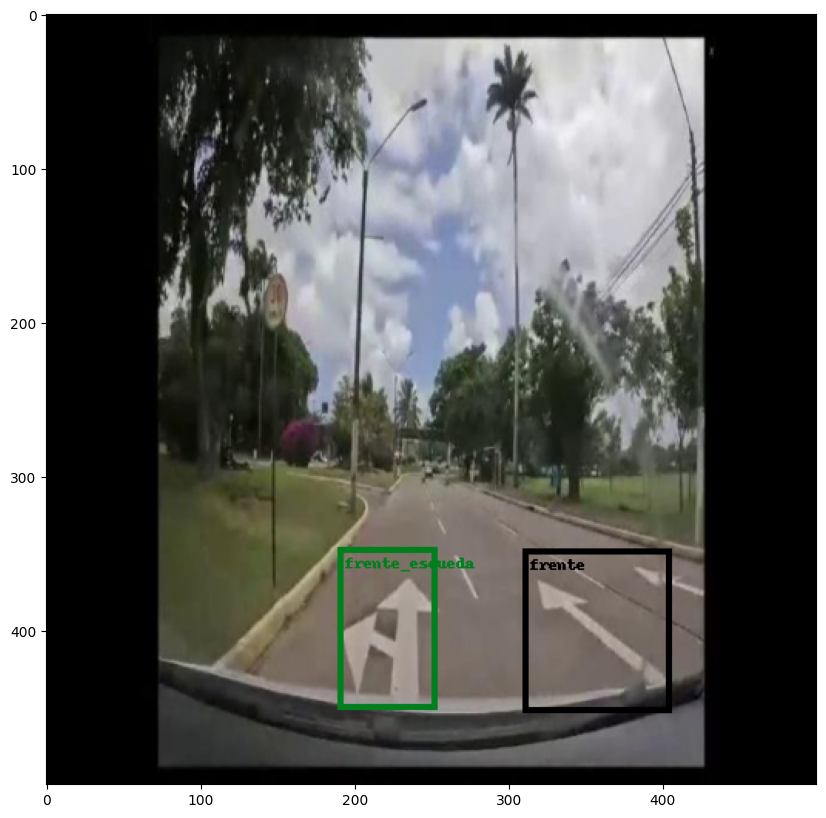

In [ ]:
img, _ = test_dataset[0]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]



fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))